# Normalizing Flows - P1
### This is an implementation of Eric Jang's tutorial (Part1) in Pytorch
[Tutorial Page](https://blog.evjang.com/2018/01/nf1.html)<br />
[Original code in Tensorflow](https://github.com/ericjang/normalizing-flows-tutorial/blob/master/nf_part1_intro.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions.transforms import Transform as dTrans
import torch.distributions.transforms as Transforms
from torch.distributions.transformed_distribution import TransformedDistribution
import torch.nn as nn

In [2]:
torch.manual_seed(0)

In [3]:
batch_size=1024
DTYPE=torch.float32
NP_DTYPE=np.float32

### Target Density
Modelling the distribution
\begin{equation}p\left(x_{1}, x_{2}\right)=\mathcal{N}\left(x 1 | \mu=1 / 4 x_{2}^{2}, \sigma=1\right) \cdot N\left(x_{2} | \mu=0, \sigma=4\right)\end{equation}

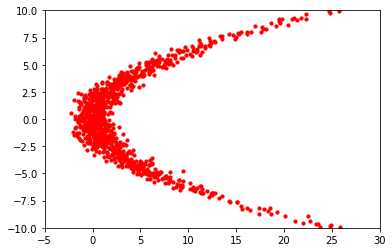

In [4]:
DATASET = 1
if DATASET == 0:
    mean = [0.4, 1]
    A = np.array([[2, .3], [-1., 4]])
    cov = A.T.dot(A)
    print(mean)
    print(cov)
    X = np.random.multivariate_normal(mean, cov, 2000)
    plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
    dataset = tf.data.Dataset.from_tensor_slices(X.astype(NP_DTYPE))
    #dataset = torch.tensor.narrow(X.astype(NP_DTYPE))
    dataset = torch.utils.data.TensorDataset(torch.tensor(X.astype(NP_DTYPE)))
    data_iterator = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    x_samples = next(iter(data_iterator))
else:
    x2_dist = torch.distributions.normal.Normal(loc=0, scale=4., validate_args=None)
    x2_samples = x2_dist.sample(sample_shape=torch.Size([batch_size]))
    x1 = torch.distributions.normal.Normal(loc=.25 * x2_samples ** 2,
    scale=torch.ones(batch_size, dtype=DTYPE))
    x1_samples = x1.sample()
    x_samples = torch.stack([x1_samples, x2_samples], dim=1)

    plt.scatter(x_samples[:, 0], x_samples[:, 1], s=10, color='red')
    plt.xlim([-5, 30])
    plt.ylim([-10, 10])


### Base Density

In [5]:
#base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))
base_dist = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros((2),dtype=DTYPE), torch.eye((2),dtype=DTYPE))

### Constructing the network

#### Affine Layer

This Affine transform is parameterized as a lower triangular matrix M plus a low rank update

\begin{equation}A = M+V \cdot D \cdot V^{T}\end{equation}

The determinant is computed using Matrix determinant lemma <br />
(Here for simplicity we set V as a vector)

#### Couldn't find the fill_triangular function in Pytorch. It is implemented below

In [6]:
def fill_triangular(x, d):
    tril_indices = torch.tril_indices(row=d, col=d, offset=0)
    m = torch.zeros((d, d))
    m[tril_indices[0], tril_indices[1]] = x
    return m

In [7]:
x = torch.tensor([1.,2.,3.,4.,5.,6.])
m = fill_triangular(x,3)
print(m)

tensor([[1., 0., 0.],
        [2., 3., 0.],
        [4., 5., 6.]])


In [8]:
class AffineModule(nn.Module):
    
    def __init__(self, input_dim, r=2, dtype=torch.float32):
        super(AffineModule, self).__init__()
        self.input_dim = input_dim
        self.V = nn.Parameter(torch.randn((1, self.input_dim), dtype=dtype))
        self.L = nn.Parameter(torch.randn((self.input_dim * (self.input_dim + 1) // 2), dtype=dtype))
        self.shift = nn.Parameter(torch.zeros((self.input_dim), dtype=dtype)) 
    
    def forward(self, x):
        M = self.fill_triangular(self.L, self.input_dim)
        scale = M + (torch.t(self.V) @ self.V)
        z = x @ scale + self.shift
        
        diag = torch.diag(M)
        detM_log = torch.sum(torch.log(torch.abs(diag)))
        log_det = torch.log(torch.abs(1 + self.V @ torch.inverse(M) @ self.V.t())) + detM_log
        return z, log_det.squeeze()
    
    def inverse(self,z):
        M = self.fill_triangular(self.L, self.input_dim)
        scale = M + (torch.t(self.V) @ self.V)
        z = z - self.shift
        x = z @ torch.inverse(scale)
        
        diag = torch.diag(M)
        detM_log = torch.sum(torch.log(torch.abs(diag)))
        log_det = torch.log(torch.abs(1 + self.V @ torch.inverse(M) @ self.V.t())) + detM_log
        return x, -log_det.squeeze()
    
    def log_abs_det_jacobian(self, x, z):
        M = self.fill_triangular(self.L, self.input_dim)
        scale = M + (torch.t(self.V) @ self.V)
        diag = torch.diag(M)
        detM_log = torch.sum(torch.log(torch.abs(diag)))
        log_det = torch.log(torch.abs(1 + self.V @ torch.inverse(M) @ self.V.t())) + detM_log
        return log_det.squeeze()
    
    @staticmethod
    def fill_triangular(x, d):
        tril_indices = torch.tril_indices(row=d, col=d, offset=0)
        m = torch.zeros((d, d))
        m[tril_indices[0], tril_indices[1]] = x
        return m

In [9]:
x = base_dist.sample(sample_shape=torch.Size([1]))
print("x: ",x)

x:  tensor([[ 0.8675, -0.5537]])


In [10]:
affine_trans = AffineModule(input_dim = 2)
z, log_det = affine_trans(x)
print("inverse of z: ", affine_trans.inverse(z)[0])

inverse of z:  tensor([[ 0.8675, -0.5537]], grad_fn=<MmBackward>)


#### Non-linea Layer

In [11]:
# quite easy to interpret - multiplying by alpha causes a contraction in volume.
class LeakyReLU(nn.Module):
    def __init__(self, alpha=0.5):
        super(LeakyReLU, self).__init__()
        self.alpha = nn.Parameter(torch.Tensor([alpha]))

    def forward(self, x):
        z = torch.where(x >= 0, x, self.alpha * x)
        log_det = self.log_abs_det_jacobian(x)
        return z, log_det

    def inverse(self, z):
        x = torch.where(z >= 0, z, 1. / self.alpha * z)
        log_det = self.inverse_log_det_jacobian(z)
        return x, log_det

    def inverse_log_det_jacobian(self, z):
        I = torch.ones_like(z)
        J_inv = torch.where(z >= 0, I, 1.0 / self.alpha * I)
        log_abs_det_J_inv = torch.log(torch.abs(J_inv))
        return torch.sum(log_abs_det_J_inv, dim=1)
    
    def log_abs_det_jacobian(self, x):
        I = torch.ones_like(x)
        J_inv = torch.where(x >= 0, I, self.alpha * I)
        log_abs_det_J_inv = torch.log(torch.abs(J_inv))
        return torch.sum(log_abs_det_J_inv, dim=1)

In [12]:
# Check the class methods
x = torch.randn(1,2)
T = LeakyReLU()
print("x: ",x)
z, log_det = T(x)
print("Inverse of z:", T.inverse(z)[0])

x:  tensor([[-0.3045,  0.6026]])
Inverse of z: tensor([[-0.3045,  0.6026]], grad_fn=<SWhereBackward>)


#### MLP Bijector

In [13]:
# Borrowed from Andrej Karpathy script https://github.com/karpathy/pytorch-normalizing-flows
class NormalizingFlow(nn.Module):
    """ A sequence of Normalizing Flows is a Normalizing Flow """

    def __init__(self, flows):
        super().__init__()
        self.flows = nn.ModuleList(flows)
    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m)
        zs = [x]
        for flow in self.flows:
            x, ld = flow(x)
            log_det += ld
            zs.append(x)
        return zs, log_det

    def inverse(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m)
        xs = [z]
        for flow in self.flows[::-1]:
            z, ld = flow.inverse(z)
            log_det += ld
            xs.append(z)
        return xs, log_det

In [14]:
d = 2
bijectors = []
num_layers = 6
for i in range(num_layers):
    bijectors.append(AffineModule(input_dim = d))
    alpha = torch.abs(torch.tensor(0.1))
    bijectors.append(LeakyReLU(alpha=alpha))
# Last layer is affine. Note that tfb.Chain takes a list of bijectors in the *reverse* order
# that they are applied..
mlp_bijector = list(reversed(bijectors[:-1]))
net = NormalizingFlow(torch.nn.ModuleList(mlp_bijector))

In [15]:
x = base_dist.sample(sample_shape=torch.Size([512]))
results, _ = net.inverse(x)

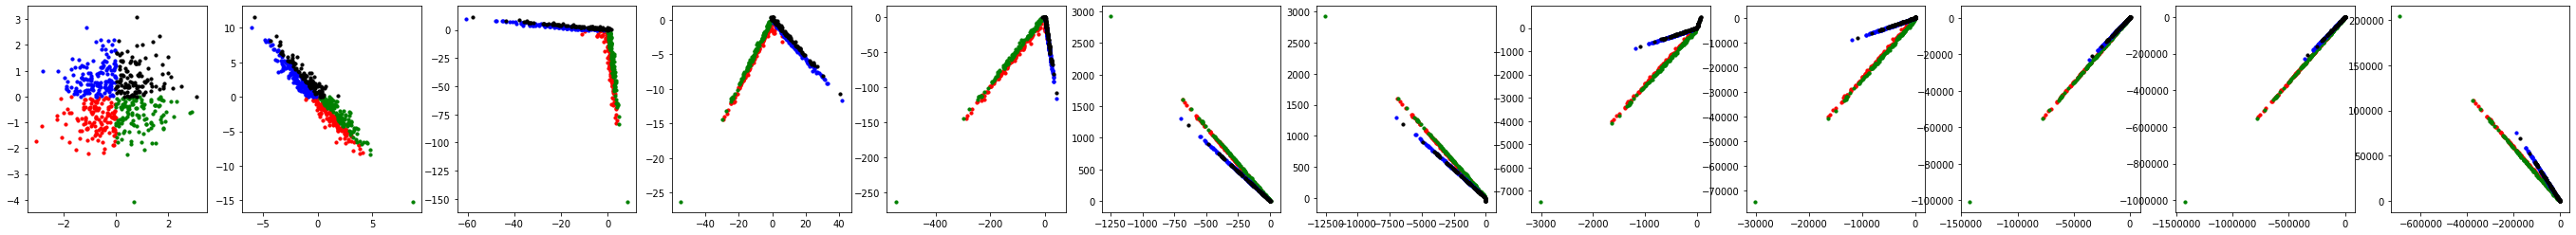

In [16]:
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0].cpu()
for i in range(len(results)):
    X1 = results[i].cpu().detach().requires_grad_(False)
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    #arr[i].set_xlim([-2, 2])
    #arr[i].set_ylim([-2, 2])
    #arr[i].set_title(names[i])
# plt.savefig('toy2d_flow.png', dpi=300)

In [17]:
class Loss(nn.Module):
    def __init__(self, dist):
        super().__init__()
        self.dist = dist
        
    def forward(self, z, log_det):
        log_p_z_mean = torch.mean(self.dist.log_prob(z[-1]))
        log_det_mean = torch.mean(log_det)
        return log_p_z_mean, log_det_mean

In [18]:
loss_fn = Loss(base_dist)
opt = torch.optim.Adam(net.parameters(), lr = 0.001)

0 54.90574645996094
10000 4.819516181945801
20000 4.707932949066162
30000 4.710633277893066
40000 4.606197834014893
50000 4.42101526260376
60000 4.430404186248779
70000 4.400286674499512
80000 4.391209602355957
90000 4.389542579650879


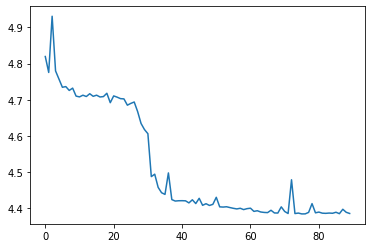

In [19]:
NUM_STEPS = int(1e5)
global_step = []
np_losses = []

for i in range(NUM_STEPS):
    z, log_det = net(x_samples)
    log_p_z_mean, log_det_mean = loss_fn(z, log_det)
    curr_loss = -log_p_z_mean - log_det_mean
    opt.zero_grad()
    curr_loss.backward()
    opt.step()
    if i % 1000 == 0:
        global_step.append(i)
        np_losses.append(curr_loss.item())
    if i % int(1e4) == 0:
        print(i, curr_loss.item())
        # print(i, log_det_mean.item())
start = 10
plt.plot(np_losses[start:])

In [20]:
x = base_dist.sample(sample_shape=torch.Size([512]))
results, _ = net.inverse(x)

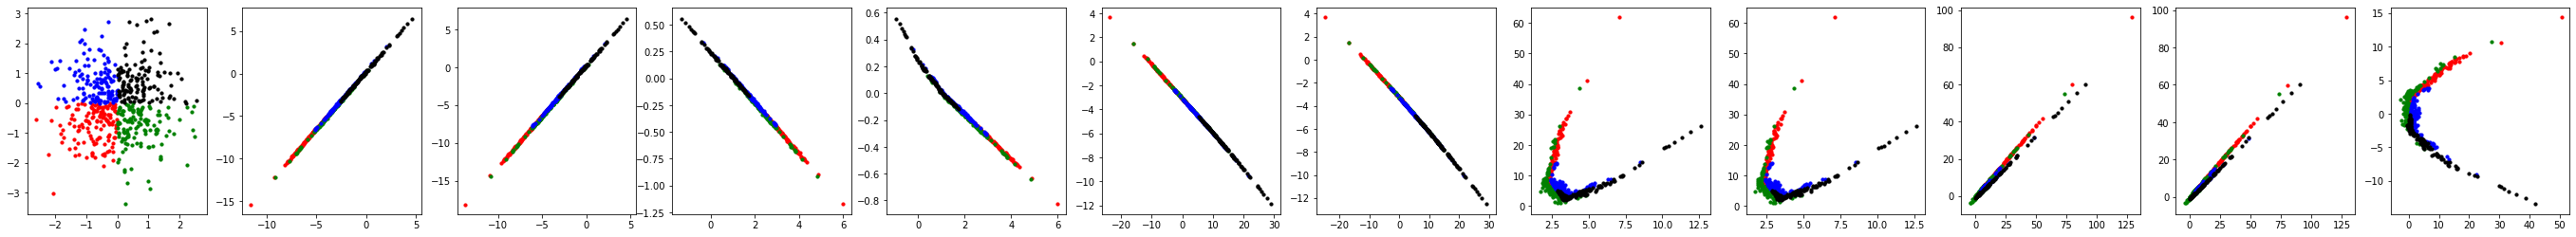

In [21]:
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i].detach().requires_grad_(False)
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    #arr[i].set_xlim([-2, 2])
    #arr[i].set_ylim([-2, 2])
    #arr[i].set_title(names[i])
# plt.savefig('toy2d_flow.png', dpi=300)

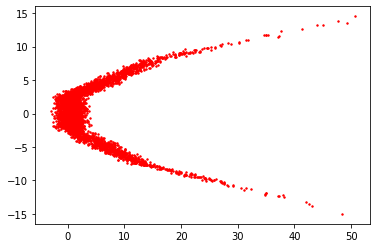

In [22]:
x = base_dist.sample(sample_shape=torch.Size([4000]))
results, _ = net.inverse(x)

X1 = results[-1].detach().numpy()
plt.scatter(X1[:, 0], X1[:, 1], color='red', s=2)
#arr[i].set_xlim([-2.5, 2.5])
#arr[i].set_ylim([-.5, .5])
plt.savefig('toy2d_out.png', dpi=300)